# A4: Common Analysis


Chang Xu

During the last two years we all have been experiencing a global pandemic. This has been tragic and disruptive to many countries and has taken a deep personal toll on many individuals and their families. 

One aspect that has been hard to miss in the last two years is the datafication of the pandemic. That is, many aspects of the individual toll of the pandemic have been collected, aggregated and re-represented as data. This datafication gives us the privilege to examine the pandemic from potentially many different perspectives to understand how it has changed lives and how it has changed society. To be honest, we are actually at the very beginning of understanding and comprehending these impacts.

During our Course Project we are going to begin taking a look at some of the social aspects of the pandemic by conducting a human centered data science analysis of some available COVID-19 data. In this Assignment A4: Common Analysis, every student in the course will work from the same datasets. I am assigned to analyze data for one specific County of the United States - New York, New York.


## Step 0: Data acquisition

The common analysis research question will require several different datasets. In this assignment, we use data from:
1. The RAW_us_confirmed_cases.csv file from the Kaggle repository of John Hopkins University COVID-19 data.
2. The CDC dataset of masking mandates by county.
3. The New York Times mask compliance survey data.

The majority of this data is by US County by Day. The mask compliance is a single shot estimator that gives us a compliance estimate for every County in the US. I carefully review the data descriptions that accompany these datasets. They each have some interesting caveats. As well, some of them are explicit with regard to the way I interpret missing data.

Import libraries needed

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Read data to dataframe

In [2]:
case_raw = pd.read_csv("raw/RAW_us_confirmed_cases.csv")
case_raw.head()

,Province_State,Admin2,UID,iso2,iso3,code3,FIPS,Country_Region,Lat,Long_,...,10/23/21,10/24/21,10/25/21,10/26/21,10/27/21,10/28/21,10/29/21,10/30/21,10/31/21,11/1/21
0,Alabama,Autauga,84001001,US,USA,840,1001.0,US,32.539527,-86.644082,...,10043,10047,10048,10061,10083,10219,10228,10239,10252,10258
1,Alabama,Baldwin,84001003,US,USA,840,1003.0,US,30.727750,-87.722071,...,37245,37258,37266,37285,37325,37350,37372,37398,37414,37425
2,Alabama,Barbour,84001005,US,USA,840,1005.0,US,31.868263,-85.387129,...,3577,3578,3578,3583,3595,3596,3596,3599,3601,3601
3,Alabama,Bibb,84001007,US,USA,840,1007.0,US,32.996421,-87.125115,...,4251,4252,4253,4256,4262,4275,4276,4278,4279,4281
4,Alabama,Blount,84001009,US,USA,840,1009.0,US,33.982109,-86.567906,...,10192,10197,10207,10227,10338,10364,10371,10395,10406,10408


For county data, I used the search and export feature on CDC to search for records specific for New York county and export all the output data to a cvs file. That's why the file only contaions data for New York county.

In [3]:
county_raw = pd.read_csv("raw/U.S._State_and_Territorial_Public_Mask_Mandates_From_April_10__2020_through_August_15__2021_by_County_by_Day.csv")
county_raw.head()

,State_Tribe_Territory,County_Name,FIPS_State,FIPS_County,date,order_code,Face_Masks_Required_in_Public,Source_of_Action,URL,Citation
0,NY,New York County,36,61,4/10/2020,2,NaN,NaN,NaN,NaN
1,NY,New York County,36,61,4/11/2020,2,NaN,NaN,NaN,NaN
2,NY,New York County,36,61,4/12/2020,2,NaN,NaN,NaN,NaN
3,NY,New York County,36,61,4/13/2020,2,NaN,NaN,NaN,NaN
4,NY,New York County,36,61,4/14/2020,2,NaN,NaN,NaN,NaN


In [4]:
mask_raw = pd.read_csv("raw/mask-use-by-county.csv")
mask_raw.head()

,COUNTYFP,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS
0,1001,0.053,0.074,0.134,0.295,0.444
1,1003,0.083,0.059,0.098,0.323,0.436
2,1005,0.067,0.121,0.120,0.201,0.491
3,1007,0.020,0.034,0.096,0.278,0.572
4,1009,0.053,0.114,0.180,0.194,0.459


## Step 1: Analyze

In this part, we are asked to answer an common question:
- How did masking policies change the progression of confirmed COVID-19 cases from February 1, 2020 through October 15, 2021?

First, we need to clean and standardize over the three datasets. In order to do that, we need to find FIPS, which is a unique identifier for counties, for New York county.

In [5]:
fips = case_raw.loc[(case_raw['Province_State'] == 'New York') & (case_raw['Admin2'] == 'New York'), 'FIPS'].values[0]
fips

36061.0

### Processing "U.S. State and Territorial Public Mask Mandates From April 10, 2020 through August 15, 2021 by County by Day" data

Add FIPS code to each row of data from New York county, so we can use it as a key to join tables later

In [6]:
county = county_raw.copy()
county['FIPS'] = fips
county

,State_Tribe_Territory,County_Name,FIPS_State,FIPS_County,date,order_code,Face_Masks_Required_in_Public,Source_of_Action,URL,Citation,FIPS
0,NY,New York County,36,61,4/10/2020,2,NaN,NaN,NaN,NaN,36061.0
1,NY,New York County,36,61,4/11/2020,2,NaN,NaN,NaN,NaN,36061.0
2,NY,New York County,36,61,4/12/2020,2,NaN,NaN,NaN,NaN,36061.0
3,NY,New York County,36,61,4/13/2020,2,NaN,NaN,NaN,NaN,36061.0
4,NY,New York County,36,61,4/14/2020,2,NaN,NaN,NaN,NaN,36061.0
...,...,...,...,...,...,...,...,...,...,...,...
488,NY,New York County,36,61,8/11/2021,2,No,Official,https://www.governor.ny.gov/sites/default/file...,"N.Y. Exec. Order No. 210 (June 25, 2021)",36061.0
489,NY,New York County,36,61,8/12/2021,2,No,Official,https://www.governor.ny.gov/sites/default/file...,"N.Y. Exec. Order No. 210 (June 25, 2021)",36061.0
490,NY,New York County,36,61,8/13/2021,2,No,Official,https://www.governor.ny.gov/sites/default/file...,"N.Y. Exec. Order No. 210 (June 25, 2021)",36061.0
491,NY,New York County,36,61,8/14/2021,2,No,Official,https://www.governor.ny.gov/sites/default/file...,"N.Y. Exec. Order No. 210 (June 25, 2021)",36061.0


Drop unnecessary columns in the table

In [7]:
county = county.drop(['FIPS_State', 'FIPS_County'], axis = 1)
county

,State_Tribe_Territory,County_Name,date,order_code,Face_Masks_Required_in_Public,Source_of_Action,URL,Citation,FIPS
0,NY,New York County,4/10/2020,2,NaN,NaN,NaN,NaN,36061.0
1,NY,New York County,4/11/2020,2,NaN,NaN,NaN,NaN,36061.0
2,NY,New York County,4/12/2020,2,NaN,NaN,NaN,NaN,36061.0
3,NY,New York County,4/13/2020,2,NaN,NaN,NaN,NaN,36061.0
4,NY,New York County,4/14/2020,2,NaN,NaN,NaN,NaN,36061.0
...,...,...,...,...,...,...,...,...,...
488,NY,New York County,8/11/2021,2,No,Official,https://www.governor.ny.gov/sites/default/file...,"N.Y. Exec. Order No. 210 (June 25, 2021)",36061.0
489,NY,New York County,8/12/2021,2,No,Official,https://www.governor.ny.gov/sites/default/file...,"N.Y. Exec. Order No. 210 (June 25, 2021)",36061.0
490,NY,New York County,8/13/2021,2,No,Official,https://www.governor.ny.gov/sites/default/file...,"N.Y. Exec. Order No. 210 (June 25, 2021)",36061.0
491,NY,New York County,8/14/2021,2,No,Official,https://www.governor.ny.gov/sites/default/file...,"N.Y. Exec. Order No. 210 (June 25, 2021)",36061.0


Convert date format for filtering convenience

In [8]:
county['date'] = pd.to_datetime(county['date'], format = '%m/%d/%Y')
county

,State_Tribe_Territory,County_Name,date,order_code,Face_Masks_Required_in_Public,Source_of_Action,URL,Citation,FIPS
0,NY,New York County,2020-04-10,2,NaN,NaN,NaN,NaN,36061.0
1,NY,New York County,2020-04-11,2,NaN,NaN,NaN,NaN,36061.0
2,NY,New York County,2020-04-12,2,NaN,NaN,NaN,NaN,36061.0
3,NY,New York County,2020-04-13,2,NaN,NaN,NaN,NaN,36061.0
4,NY,New York County,2020-04-14,2,NaN,NaN,NaN,NaN,36061.0
...,...,...,...,...,...,...,...,...,...
488,NY,New York County,2021-08-11,2,No,Official,https://www.governor.ny.gov/sites/default/file...,"N.Y. Exec. Order No. 210 (June 25, 2021)",36061.0
489,NY,New York County,2021-08-12,2,No,Official,https://www.governor.ny.gov/sites/default/file...,"N.Y. Exec. Order No. 210 (June 25, 2021)",36061.0
490,NY,New York County,2021-08-13,2,No,Official,https://www.governor.ny.gov/sites/default/file...,"N.Y. Exec. Order No. 210 (June 25, 2021)",36061.0
491,NY,New York County,2021-08-14,2,No,Official,https://www.governor.ny.gov/sites/default/file...,"N.Y. Exec. Order No. 210 (June 25, 2021)",36061.0


Since the data is already between February 1, 2020 through October 15, 2021, we can keep it all.

### Processing "Raw U.S. Confirmed Cases" data

Before we start the similar processing, we need to make dates and their respective cases columns so we can process.

In [9]:
case = case_raw.copy()
case = pd.melt(case, id_vars = case.columns[0:11], var_name = 'date', value_name = 'cases')
case

,Province_State,Admin2,UID,iso2,iso3,code3,FIPS,Country_Region,Lat,Long_,Combined_Key,date,cases
0,Alabama,Autauga,84001001,US,USA,840,1001.0,US,32.539527,-86.644082,"Autauga, Alabama, US",1/22/20,0
1,Alabama,Baldwin,84001003,US,USA,840,1003.0,US,30.727750,-87.722071,"Baldwin, Alabama, US",1/22/20,0
2,Alabama,Barbour,84001005,US,USA,840,1005.0,US,31.868263,-85.387129,"Barbour, Alabama, US",1/22/20,0
3,Alabama,Bibb,84001007,US,USA,840,1007.0,US,32.996421,-87.125115,"Bibb, Alabama, US",1/22/20,0
4,Alabama,Blount,84001009,US,USA,840,1009.0,US,33.982109,-86.567906,"Blount, Alabama, US",1/22/20,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2172295,Wyoming,Teton,84056039,US,USA,840,56039.0,US,43.935225,-110.589080,"Teton, Wyoming, US",11/1/21,5218
2172296,Wyoming,Uinta,84056041,US,USA,840,56041.0,US,41.287818,-110.547578,"Uinta, Wyoming, US",11/1/21,3843
2172297,Wyoming,Unassigned,84090056,US,USA,840,90056.0,US,0.000000,0.000000,"Unassigned, Wyoming, US",11/1/21,0
2172298,Wyoming,Washakie,84056043,US,USA,840,56043.0,US,43.904516,-107.680187,"Washakie, Wyoming, US",11/1/21,1745


Drop unwanted columns

In [10]:
case = case.drop(['Province_State', 'Admin2', 'UID', 'iso2', 'iso3', 'code3', 'Country_Region', 'Lat', 'Long_'], axis = 1)
case

,FIPS,Combined_Key,date,cases
0,1001.0,"Autauga, Alabama, US",1/22/20,0
1,1003.0,"Baldwin, Alabama, US",1/22/20,0
2,1005.0,"Barbour, Alabama, US",1/22/20,0
3,1007.0,"Bibb, Alabama, US",1/22/20,0
4,1009.0,"Blount, Alabama, US",1/22/20,0
...,...,...,...,...
2172295,56039.0,"Teton, Wyoming, US",11/1/21,5218
2172296,56041.0,"Uinta, Wyoming, US",11/1/21,3843
2172297,90056.0,"Unassigned, Wyoming, US",11/1/21,0
2172298,56043.0,"Washakie, Wyoming, US",11/1/21,1745


Select the case data only for New York County, New York

In [11]:
case = case.loc[case['FIPS'] == fips]
case

,FIPS,Combined_Key,date,cases
1932,36061.0,"New York, New York, US",1/22/20,0
5274,36061.0,"New York, New York, US",1/23/20,0
8616,36061.0,"New York, New York, US",1/24/20,0
11958,36061.0,"New York, New York, US",1/25/20,0
15300,36061.0,"New York, New York, US",1/26/20,0
...,...,...,...,...
2157522,36061.0,"New York, New York, US",10/28/21,169180
2160864,36061.0,"New York, New York, US",10/29/21,169321
2164206,36061.0,"New York, New York, US",10/30/21,169504
2167548,36061.0,"New York, New York, US",10/31/21,169665


Standardize the time to make it easy for query

In [12]:
case['date'] = pd.to_datetime(case['date'], format = '%m/%d/%y')
case

<ipython-input-12-669928a77b66>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  case['date'] = pd.to_datetime(case['date'], format = '%m/%d/%y')


,FIPS,Combined_Key,date,cases
1932,36061.0,"New York, New York, US",2020-01-22,0
5274,36061.0,"New York, New York, US",2020-01-23,0
8616,36061.0,"New York, New York, US",2020-01-24,0
11958,36061.0,"New York, New York, US",2020-01-25,0
15300,36061.0,"New York, New York, US",2020-01-26,0
...,...,...,...,...
2157522,36061.0,"New York, New York, US",2021-10-28,169180
2160864,36061.0,"New York, New York, US",2021-10-29,169321
2164206,36061.0,"New York, New York, US",2021-10-30,169504
2167548,36061.0,"New York, New York, US",2021-10-31,169665


Get only the data from February 1, 2020 to October 15, 2021

In [13]:
case = case.loc[(case['date'] >= '2020-02-01') & (case['date'] <= '2021-10-15')].reset_index().drop(['index'], axis = 1)
case

,FIPS,Combined_Key,date,cases
0,36061.0,"New York, New York, US",2020-02-01,0
1,36061.0,"New York, New York, US",2020-02-02,0
2,36061.0,"New York, New York, US",2020-02-03,0
3,36061.0,"New York, New York, US",2020-02-04,0
4,36061.0,"New York, New York, US",2020-02-05,0
...,...,...,...,...
618,36061.0,"New York, New York, US",2021-10-11,166253
619,36061.0,"New York, New York, US",2021-10-12,166413
620,36061.0,"New York, New York, US",2021-10-13,166586
621,36061.0,"New York, New York, US",2021-10-14,166797


### Combioning the two datasets to get a main table that we will mostly use for our analysis

In [14]:
combined = case.merge(county, how = 'left', on = ['FIPS', 'date'])
combined

,FIPS,Combined_Key,date,cases,State_Tribe_Territory,County_Name,order_code,Face_Masks_Required_in_Public,Source_of_Action,URL,Citation
0,36061.0,"New York, New York, US",2020-02-01,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,36061.0,"New York, New York, US",2020-02-02,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,36061.0,"New York, New York, US",2020-02-03,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,36061.0,"New York, New York, US",2020-02-04,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,36061.0,"New York, New York, US",2020-02-05,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
618,36061.0,"New York, New York, US",2021-10-11,166253,NaN,NaN,NaN,NaN,NaN,NaN,NaN
619,36061.0,"New York, New York, US",2021-10-12,166413,NaN,NaN,NaN,NaN,NaN,NaN,NaN
620,36061.0,"New York, New York, US",2021-10-13,166586,NaN,NaN,NaN,NaN,NaN,NaN,NaN
621,36061.0,"New York, New York, US",2021-10-14,166797,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Make binary answers for "Face_Masks_Required_in_Public"

In [15]:
combined['Face_Masks_Required_in_Public'] = combined['Face_Masks_Required_in_Public'] == 'Yes'
combined

,FIPS,Combined_Key,date,cases,State_Tribe_Territory,County_Name,order_code,Face_Masks_Required_in_Public,Source_of_Action,URL,Citation
0,36061.0,"New York, New York, US",2020-02-01,0,NaN,NaN,NaN,False,NaN,NaN,NaN
1,36061.0,"New York, New York, US",2020-02-02,0,NaN,NaN,NaN,False,NaN,NaN,NaN
2,36061.0,"New York, New York, US",2020-02-03,0,NaN,NaN,NaN,False,NaN,NaN,NaN
3,36061.0,"New York, New York, US",2020-02-04,0,NaN,NaN,NaN,False,NaN,NaN,NaN
4,36061.0,"New York, New York, US",2020-02-05,0,NaN,NaN,NaN,False,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
618,36061.0,"New York, New York, US",2021-10-11,166253,NaN,NaN,NaN,False,NaN,NaN,NaN
619,36061.0,"New York, New York, US",2021-10-12,166413,NaN,NaN,NaN,False,NaN,NaN,NaN
620,36061.0,"New York, New York, US",2021-10-13,166586,NaN,NaN,NaN,False,NaN,NaN,NaN
621,36061.0,"New York, New York, US",2021-10-14,166797,NaN,NaN,NaN,False,NaN,NaN,NaN


Rename the column to make it clear that the "cases" is for cumulative confirmed cases

In [16]:
combined = combined.rename({'cases': 'Cumulative_Cases'}, axis = 1)
combined

,FIPS,Combined_Key,date,Cumulative_Cases,State_Tribe_Territory,County_Name,order_code,Face_Masks_Required_in_Public,Source_of_Action,URL,Citation
0,36061.0,"New York, New York, US",2020-02-01,0,NaN,NaN,NaN,False,NaN,NaN,NaN
1,36061.0,"New York, New York, US",2020-02-02,0,NaN,NaN,NaN,False,NaN,NaN,NaN
2,36061.0,"New York, New York, US",2020-02-03,0,NaN,NaN,NaN,False,NaN,NaN,NaN
3,36061.0,"New York, New York, US",2020-02-04,0,NaN,NaN,NaN,False,NaN,NaN,NaN
4,36061.0,"New York, New York, US",2020-02-05,0,NaN,NaN,NaN,False,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
618,36061.0,"New York, New York, US",2021-10-11,166253,NaN,NaN,NaN,False,NaN,NaN,NaN
619,36061.0,"New York, New York, US",2021-10-12,166413,NaN,NaN,NaN,False,NaN,NaN,NaN
620,36061.0,"New York, New York, US",2021-10-13,166586,NaN,NaN,NaN,False,NaN,NaN,NaN
621,36061.0,"New York, New York, US",2021-10-14,166797,NaN,NaN,NaN,False,NaN,NaN,NaN


Calculate daily confirmed cases

In [17]:
combined['Daily_Cases'] = combined['Cumulative_Cases'].diff(periods = 1)
combined

,FIPS,Combined_Key,date,Cumulative_Cases,State_Tribe_Territory,County_Name,order_code,Face_Masks_Required_in_Public,Source_of_Action,URL,Citation,Daily_Cases
0,36061.0,"New York, New York, US",2020-02-01,0,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN
1,36061.0,"New York, New York, US",2020-02-02,0,NaN,NaN,NaN,False,NaN,NaN,NaN,0.0
2,36061.0,"New York, New York, US",2020-02-03,0,NaN,NaN,NaN,False,NaN,NaN,NaN,0.0
3,36061.0,"New York, New York, US",2020-02-04,0,NaN,NaN,NaN,False,NaN,NaN,NaN,0.0
4,36061.0,"New York, New York, US",2020-02-05,0,NaN,NaN,NaN,False,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
618,36061.0,"New York, New York, US",2021-10-11,166253,NaN,NaN,NaN,False,NaN,NaN,NaN,240.0
619,36061.0,"New York, New York, US",2021-10-12,166413,NaN,NaN,NaN,False,NaN,NaN,NaN,160.0
620,36061.0,"New York, New York, US",2021-10-13,166586,NaN,NaN,NaN,False,NaN,NaN,NaN,173.0
621,36061.0,"New York, New York, US",2021-10-14,166797,NaN,NaN,NaN,False,NaN,NaN,NaN,211.0


The infection time series is a set of slopes. We want to get the data for change in slope over time.

In [18]:
combined['Slop'] = combined['Cumulative_Cases'].diff(periods = 1)
combined

,FIPS,Combined_Key,date,Cumulative_Cases,State_Tribe_Territory,County_Name,order_code,Face_Masks_Required_in_Public,Source_of_Action,URL,Citation,Daily_Cases,Slop
0,36061.0,"New York, New York, US",2020-02-01,0,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN
1,36061.0,"New York, New York, US",2020-02-02,0,NaN,NaN,NaN,False,NaN,NaN,NaN,0.0,0.0
2,36061.0,"New York, New York, US",2020-02-03,0,NaN,NaN,NaN,False,NaN,NaN,NaN,0.0,0.0
3,36061.0,"New York, New York, US",2020-02-04,0,NaN,NaN,NaN,False,NaN,NaN,NaN,0.0,0.0
4,36061.0,"New York, New York, US",2020-02-05,0,NaN,NaN,NaN,False,NaN,NaN,NaN,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
618,36061.0,"New York, New York, US",2021-10-11,166253,NaN,NaN,NaN,False,NaN,NaN,NaN,240.0,240.0
619,36061.0,"New York, New York, US",2021-10-12,166413,NaN,NaN,NaN,False,NaN,NaN,NaN,160.0,160.0
620,36061.0,"New York, New York, US",2021-10-13,166586,NaN,NaN,NaN,False,NaN,NaN,NaN,173.0,173.0
621,36061.0,"New York, New York, US",2021-10-14,166797,NaN,NaN,NaN,False,NaN,NaN,NaN,211.0,211.0


Calculating the derivative function - change in slope over time

In [19]:
# copy the table to prevent I mess up...
df = combined.copy()
df['Total_Population'] = 1694251

The initial population is what I look up from the table. Here I calculate the infection rate and the smooth infection rate considering a window of 7 days and take the average (so it's more meaningful when it comes to ploting the figure). 

There are a few assumptions made:
1. Assume the population for the entire time period remains the same
2. Assume people have the same probability of getting COVID, regardless of whether they wear masks or not

I may need to refine how I calculate this slope later

In [20]:
df['Susceptible_Population'] = df['Total_Population'] - df['Cumulative_Cases']

df['Infection_Rate'] = (df['Daily_Cases'] / df['Susceptible_Population']) * 100

df['7Day_Average_Cases'] = df['Daily_Cases'].rolling(window = 7).mean()
df['Infection_Rate_Smooth'] = (df['7Day_Average_Cases'] / df['Susceptible_Population']) * 100

df

,FIPS,Combined_Key,date,Cumulative_Cases,State_Tribe_Territory,County_Name,order_code,Face_Masks_Required_in_Public,Source_of_Action,URL,Citation,Daily_Cases,Slop,Total_Population,Susceptible_Population,Infection_Rate,7Day_Average_Cases,Infection_Rate_Smooth
0,36061.0,"New York, New York, US",2020-02-01,0,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,1694251,1694251,NaN,NaN,NaN
1,36061.0,"New York, New York, US",2020-02-02,0,NaN,NaN,NaN,False,NaN,NaN,NaN,0.0,0.0,1694251,1694251,0.000000,NaN,NaN
2,36061.0,"New York, New York, US",2020-02-03,0,NaN,NaN,NaN,False,NaN,NaN,NaN,0.0,0.0,1694251,1694251,0.000000,NaN,NaN
3,36061.0,"New York, New York, US",2020-02-04,0,NaN,NaN,NaN,False,NaN,NaN,NaN,0.0,0.0,1694251,1694251,0.000000,NaN,NaN
4,36061.0,"New York, New York, US",2020-02-05,0,NaN,NaN,NaN,False,NaN,NaN,NaN,0.0,0.0,1694251,1694251,0.000000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
618,36061.0,"New York, New York, US",2021-10-11,166253,NaN,NaN,NaN,False,NaN,NaN,NaN,240.0,240.0,1694251,1527998,0.015707,219.000000,0.014332
619,36061.0,"New York, New York, US",2021-10-12,166413,NaN,NaN,NaN,False,NaN,NaN,NaN,160.0,160.0,1694251,1527838,0.010472,212.714286,0.013923
620,36061.0,"New York, New York, US",2021-10-13,166586,NaN,NaN,NaN,False,NaN,NaN,NaN,173.0,173.0,1694251,1527665,0.011324,207.000000,0.013550
621,36061.0,"New York, New York, US",2021-10-14,166797,NaN,NaN,NaN,False,NaN,NaN,NaN,211.0,211.0,1694251,1527454,0.013814,198.857143,0.013019


Save data to the directory for A5 anlysis

In [24]:
df.to_csv("a4_data.csv")

### Analyze Mask Compliance Data

In [83]:
mask = mask_raw.copy()
mask = mask.loc[mask['COUNTYFP'] == fips]
mask

,COUNTYFP,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS
1858,36061,0.02,0.016,0.04,0.121,0.803


## Step 2:  Visualize

In this step, I create a graph that visualizes how the course of the disease was changed by masking policies. For New York County, New York, I create a time series showing the changes in the derivative function of the rate of infection. My graph indicates days where masking policies were in effect (or not) and whether the difference in the derivative function was significant. Optionally, I add a second time series that shows the actual rate of infection.

### Plot for Cumulative Confirmed Cases

We use green color to indicate the period when face masks are required in public.

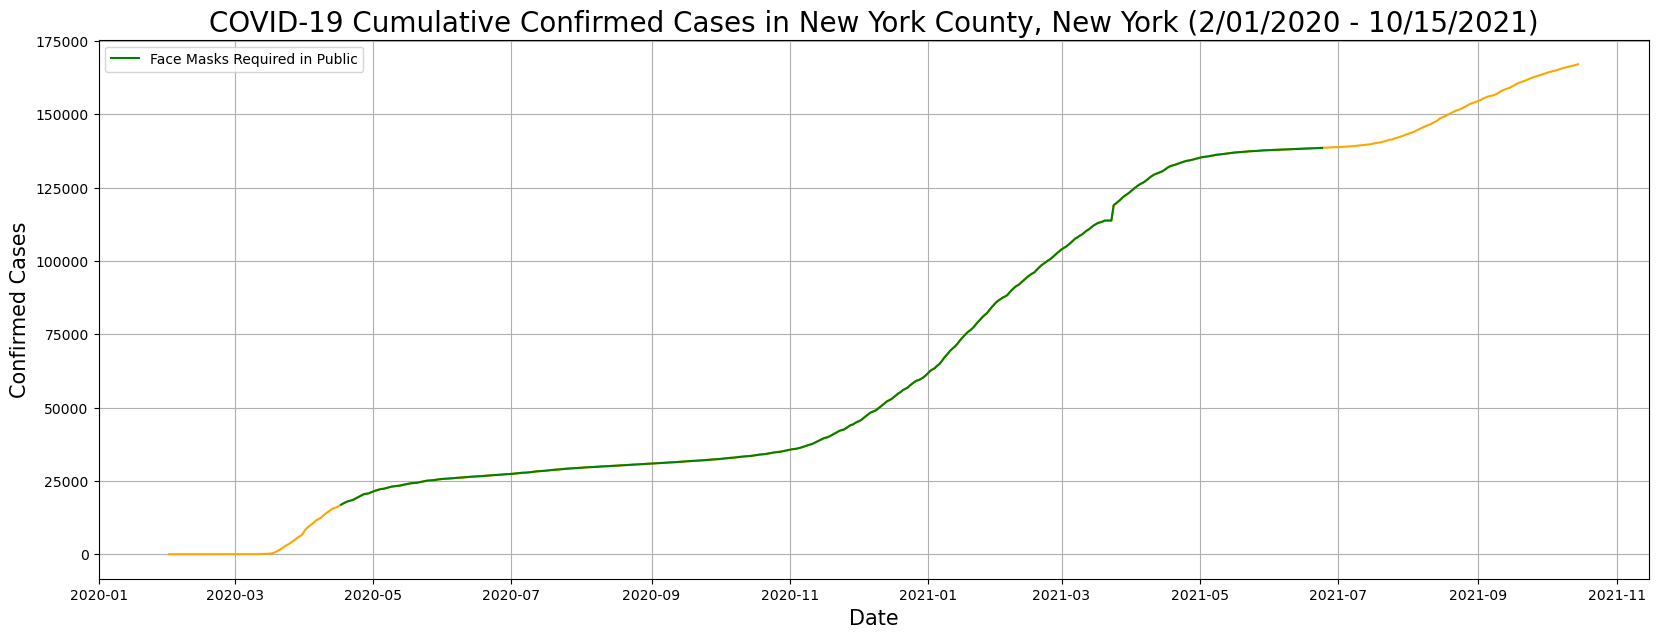

In [106]:
plt.figure(figsize=(20,7))

plt.plot(combined['date'], combined['Cumulative_Cases'], color = 'orange')

sub_x = combined.loc[combined['Face_Masks_Required_in_Public'], 'date']
sub_y = combined.loc[combined['Face_Masks_Required_in_Public'], 'Cumulative_Cases']
plt.plot(sub_x, sub_y, color = 'green', label = 'Face Masks Required in Public')

plt.xlabel('Date', fontsize = 15)
plt.ylabel('Confirmed Cases', fontsize = 15)
plt.title('COVID-19 Cumulative Confirmed Cases in New York County, New York (2/01/2020 - 10/15/2021)', fontsize = 20)

plt.grid()
plt.legend()
plt.show()

### Plot for Daily Confirmed Cases

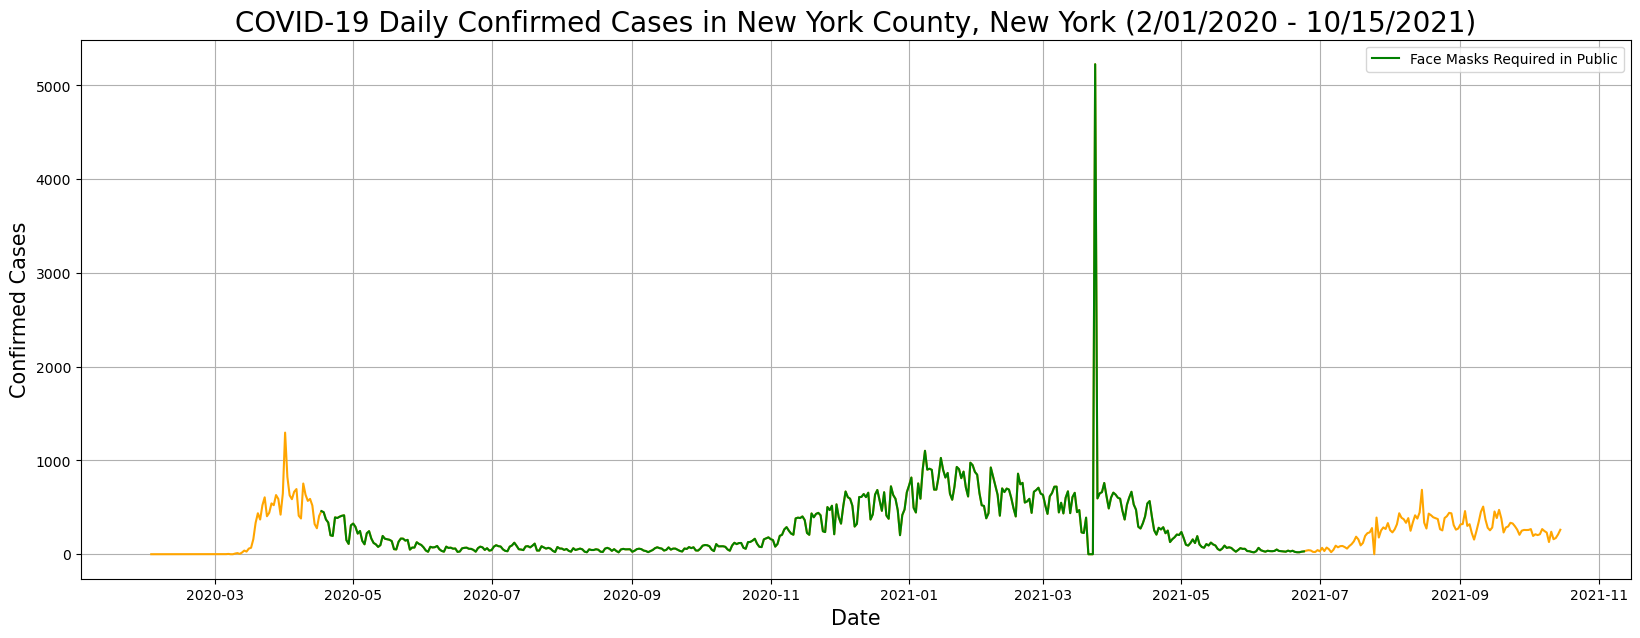

In [93]:
plt.figure(figsize=(20,7))

plt.plot(combined['date'], combined['Daily_Cases'], color = 'orange')

sub_x = combined.loc[combined['Face_Masks_Required_in_Public'], 'date']
sub_y = combined.loc[combined['Face_Masks_Required_in_Public'], 'Daily_Cases']
plt.plot(sub_x, sub_y, color = 'green', label = 'Face Masks Required in Public')

plt.xlabel('Date', fontsize = 15)
plt.ylabel('Confirmed Cases', fontsize = 15)
plt.title('COVID-19 Daily Confirmed Cases in New York County, New York (2/01/2020 - 10/15/2021)', fontsize = 20)

plt.grid()
plt.legend()
plt.show()

### Plot for changes in the derivative function of the rate of infection

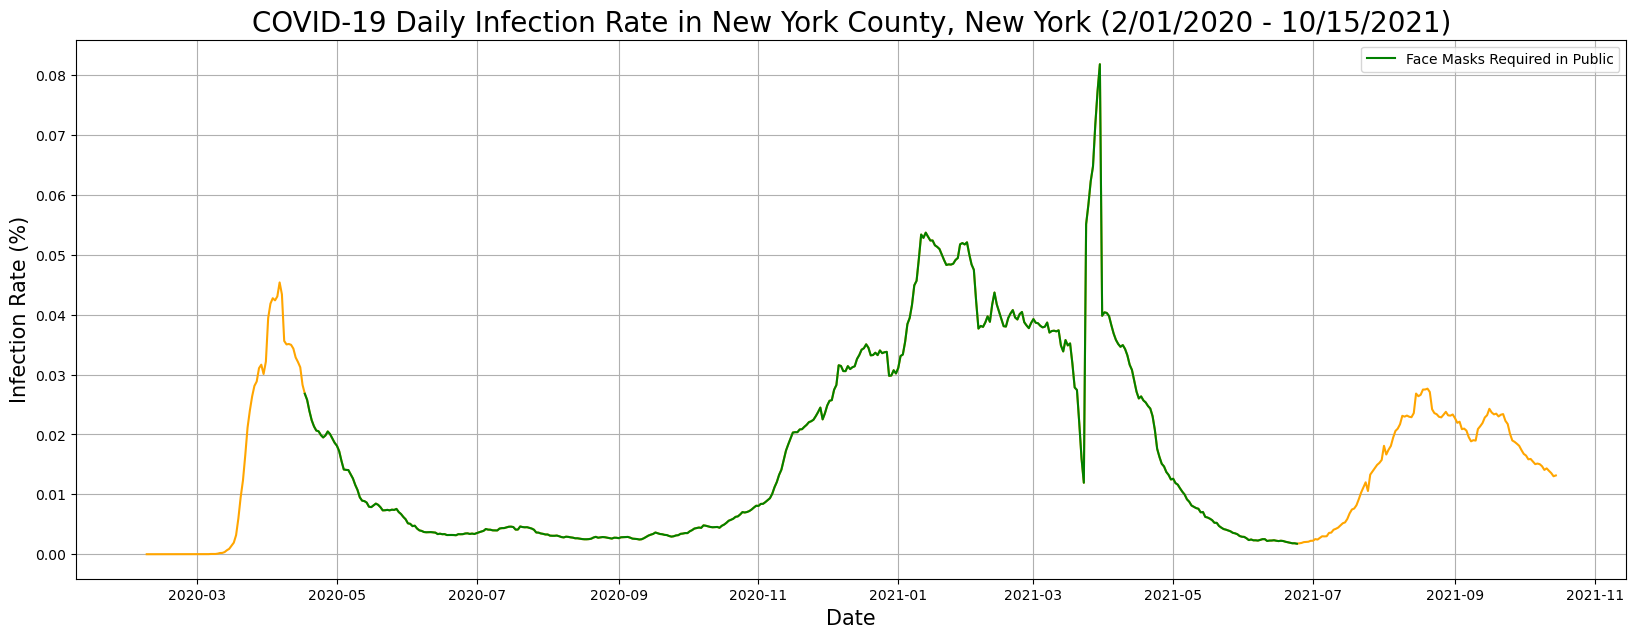

In [144]:
plt.figure(figsize=(20,7))

plt.plot(df['date'], df['Infection_Rate_Smooth'], color = 'orange')

sub_x = df.loc[df['Face_Masks_Required_in_Public'], 'date']
sub_y = df.loc[df['Face_Masks_Required_in_Public'], 'Infection_Rate_Smooth']
plt.plot(sub_x, sub_y, color = 'green', label = 'Face Masks Required in Public')

plt.xlabel('Date', fontsize = 15)
plt.ylabel('Infection Rate (%)', fontsize = 15)
plt.title('COVID-19 Daily Infection Rate in New York County, New York (2/01/2020 - 10/15/2021)', fontsize = 20)

plt.grid()
plt.legend()
plt.show()

### Plot for Mask Compliance

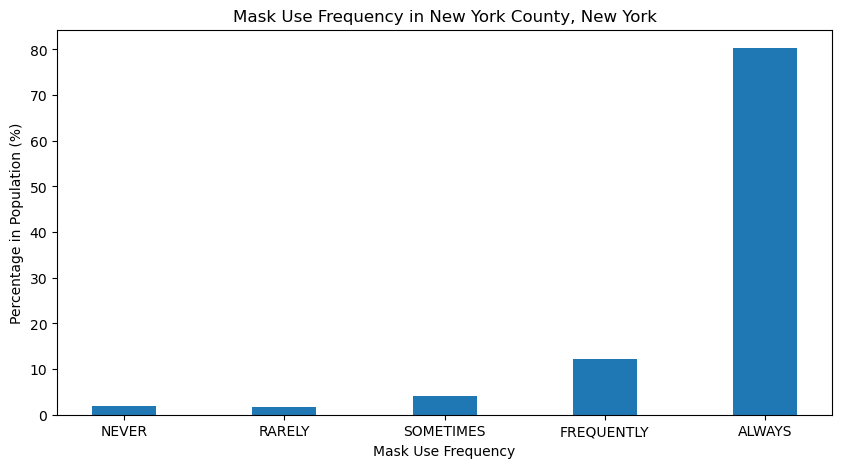

In [104]:
data = {'NEVER':2, 'RARELY':1.6, 'SOMETIMES':4, 'FREQUENTLY':12.1, 'ALWAYS':80.3 }
atitude = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(atitude, values, width = 0.4)
 
plt.xlabel("Mask Use Frequency")
plt.ylabel("Percentage in Population (%)")

plt.title("Mask Use Frequency in New York County, New York")


plt.show()

## Step 3: Write & Reflect

My data, analysis and observation are solely for New York County, New York.

Based on the figures shown, we can observe that the rate of confirmed cases decreases from April 2020 to July 2020, when mask wearing first became required in public. It seems like wearing a mask effectively slows down the infection rate and as more people start to wear masks, the lower the infection rate.

Then from July 2020 to November 2020, the infection rate (rate of increase in confirmed cases) stays relatively the same, keeping the confirmed cases (cumulative and daily) low compared to the first period of the pandemic (when covid first started to spread and wearing masks in public was not required). We can therefore still say that the policy of requiring mask wearing in public is still effective.

However, it is interesting to see that, after some time (starting from November 2020), while mask wearing is still required in public, the rate of confirmed cases starts to rise. I think this is because after a long time of wearing (for about 7 months since the rule was first enforced), people became a bit tired psychologically and started to take their masks off. This aligns with the social news I find during that period. People started gathering and partying with small groups again, and during those events, they typically did not wear masks. Therefore, the rate of confirmed COVID cases starts to rise again.

The rate of increased confirmed cases slows down again in around June 2021. To my knowledge, that was the time where the data of confirmed cases looked really bad and vaccination was strongly encouraged everywhere (actually I think a lot of people had already finished their two shots vaccination by that time). 

Then, after July 2021, when mask wearing in public is no longer required, we can observe another small surge in confirmed cases. However, since most people are already vaccinated at this moment, the surge is not as large as before and the gradient is relatively small.

Overall, people form New York County, New York have a good compliance with the mask policy, and we can see most people wear masks always (80.3%) or frequently (12.1%). People who are reluctant to wear masks are just a minority in the county.